# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [28]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the images directly to the model.
    - The two Conv2D layers below learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](images/conv_layer.png)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](images/conv.png)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="images/MaxpoolSample2.png" width="600" hight="600" align="left"/>

In [3]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.kera
        s.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [9]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [10]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3
98/98 [==============================] - 5s 9ms/step - loss: 1.7538 - accuracy: 0.3629
Epoch 2/3
98/98 [==============================] - 1s 7ms/step - loss: 1.3875 - accuracy: 0.5024
Epoch 3/3
98/98 [==============================] - 1s 7ms/step - loss: 1.2389 - accuracy: 0.5606


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

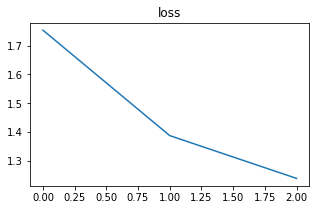

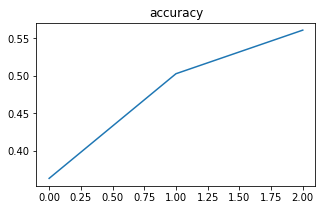

In [11]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 96.53%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). 

In [12]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 1.0937 - accuracy: 0.6190 - 521ms/epoch - 2ms/step
accuracy: 61.90%
CPU times: user 918 ms, sys: 1.33 s, total: 2.25 s
Wall time: 1.97 s


We can also again check the confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 0s 847us/step
[[664  14  66  36   3  10  13  14 127  53]
 [ 28 700  15  20   0   4   9  12  55 157]
 [ 85   7 529 108  39  91  65  41  19  16]
 [ 15   6  98 521  27 173  81  52  17  10]
 [ 43   2 235 108 336  40  94 118  18   6]
 [ 15   3  89 209  21 550  27  71  10   5]
 [  4   4  78 102  23  31 721  20   8   9]
 [ 18   1  48  65  25  90   8 720   5  20]
 [ 99  48  14  30   1   8   8   6 740  46]
 [ 38 105  15  23   3   7  16  32  52 709]]

Classification accuracy for each class:

0: 0.6640
1: 0.7000
2: 0.5290
3: 0.5210
4: 0.3360
5: 0.5500
6: 0.7210
7: 0.7200
8: 0.7400
9: 0.7090


### More verbose training

This approach explicitly handles the looping over data. It will be helpful in future weeks for diving in and optimizing

In [14]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [15]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [16]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [17]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 1.3 seconds for epoch #0
beginning epoch 1
took 0.9 seconds for epoch #1
beginning epoch 2
took 0.9 seconds for epoch #2


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.69%, although it varies randomly.

Epoch 1/10
50/50 [==============================] - 1s 16ms/step - loss: 2.0114 - accuracy: 0.2668
Epoch 2/10
50/50 [==============================] - 1s 12ms/step - loss: 1.7425 - accuracy: 0.3724
Epoch 3/10
50/50 [==============================] - 1s 12ms/step - loss: 1.6128 - accuracy: 0.4188
Epoch 4/10
50/50 [==============================] - 1s 12ms/step - loss: 1.5359 - accuracy: 0.4474
Epoch 5/10
50/50 [==============================] - 1s 12ms/step - loss: 1.4772 - accuracy: 0.4727
Epoch 6/10
50/50 [==============================] - 1s 12ms/step - loss: 1.4260 - accuracy: 0.4953
Epoch 7/10
50/50 [==============================] - 1s 12ms/step - loss: 1.3896 - accuracy: 0.5054
Epoch 8/10
50/50 [==============================] - 1s 12ms/step - loss: 1.3502 - accuracy: 0.5198
Epoch 9/10
50/50 [==============================] - 1s 12ms/step - loss: 1.3301 - accuracy: 0.5261
Epoch 10/10
50/50 [==============================] - 1s 11ms/step - loss: 1.2968 - accuracy: 0.5395


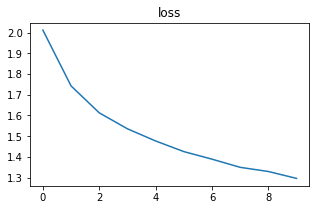

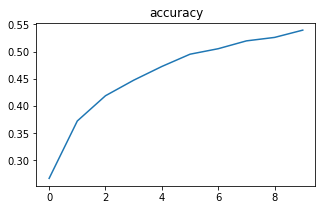

In [19]:
#Increasing epochs,learning rate, number of neurons in the hidden layer, optimizer
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adamax", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

# This took 43 seconds per epoch on my laptop
batch_size = 1012
epochs = 10
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [20]:
# (history.epoch,history.history['accuracy'])*100

In [29]:
## Chaniging the model
class CIFAR10Classifier_mod(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(256, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')
        self.dense_8 = tf.keras.layers.Dense(15, activation='softmax')
        #self.dense_9 = tf.keras.layers.Dense(20, activation='softmax')
        #self.drop_9 = tf.keras.layers.Dropout(0.25)
        #self.dense_10 = tf.keras.layers.Dense(128, activation='relu')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)
        x = self.dense_8(x)
        #x = self.drop_9(x)
        #x = tf.keras.layers.Flatten()(x)
#       x = self.dense_10(x)

        return x

Epoch 1/35
100/100 [==============================] - 1s 7ms/step - loss: 2.5721 - accuracy: 0.1527
Epoch 2/35
100/100 [==============================] - 1s 7ms/step - loss: 2.4684 - accuracy: 0.2100
Epoch 3/35
100/100 [==============================] - 1s 7ms/step - loss: 2.3897 - accuracy: 0.2143
Epoch 4/35
100/100 [==============================] - 1s 7ms/step - loss: 2.3165 - accuracy: 0.2259
Epoch 5/35
100/100 [==============================] - 1s 7ms/step - loss: 2.2467 - accuracy: 0.2833
Epoch 6/35
100/100 [==============================] - 1s 7ms/step - loss: 2.1830 - accuracy: 0.2901
Epoch 7/35
100/100 [==============================] - 1s 7ms/step - loss: 2.1202 - accuracy: 0.2992
Epoch 8/35
100/100 [==============================] - 1s 7ms/step - loss: 2.0632 - accuracy: 0.3074
Epoch 9/35
100/100 [==============================] - 1s 8ms/step - loss: 2.0101 - accuracy: 0.3118
Epoch 10/35
100/100 [==============================] - 1s 7ms/step - loss: 1.9599 - accuracy: 0.3187

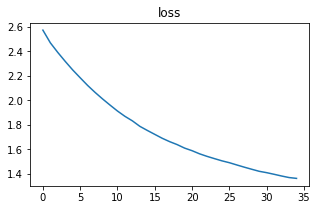

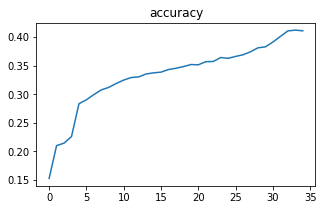

In [34]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier_mod()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="SGD", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

# This took 43 seconds per epoch on my laptop
batch_size = 500
epochs = 35
lr = .015

history, cnn_model = train_network_concise(batch_size, epochs, lr)

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

Epoch 1/35
100/100 [==============================] - 1s 7ms/step - loss: 2.5284 - accuracy: 0.1924
Epoch 2/35
100/100 [==============================] - 1s 7ms/step - loss: 2.3870 - accuracy: 0.2340
Epoch 3/35
100/100 [==============================] - 1s 7ms/step - loss: 2.2764 - accuracy: 0.2425
Epoch 4/35
100/100 [==============================] - 1s 7ms/step - loss: 2.1856 - accuracy: 0.2508
Epoch 5/35
100/100 [==============================] - 1s 7ms/step - loss: 2.1112 - accuracy: 0.2629
Epoch 6/35
100/100 [==============================] - 1s 7ms/step - loss: 2.0478 - accuracy: 0.2735
Epoch 7/35
100/100 [==============================] - 1s 7ms/step - loss: 1.9877 - accuracy: 0.2860
Epoch 8/35
100/100 [==============================] - 1s 7ms/step - loss: 1.9390 - accuracy: 0.3008
Epoch 9/35
100/100 [==============================] - 1s 9ms/step - loss: 1.8932 - accuracy: 0.3193
Epoch 10/35
100/100 [==============================] - 1s 7ms/step - loss: 1.8469 - accuracy: 0.3240

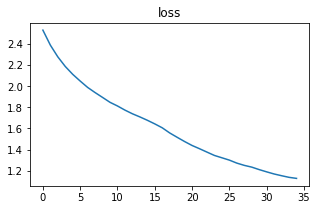

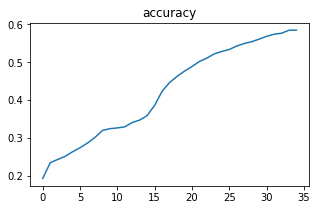

In [36]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier_mod()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

# This took 43 seconds per epoch on my laptop
batch_size = 500
epochs = 35
lr = .015

history, cnn_model = train_network_concise(batch_size, epochs, lr)

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');